In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

%config InlineBackend.figure_format = 'retina'

In [2]:
sample_size = 1000

# 1. Variable Creation
#### 1.1 Categoricals
* `size`: This will be correlated with price. It will not be correlated with color.
* `color`: This will not be correlated with price or size. 
* `container`: The container used to ship item. This will be correlated with size (a larger item will need a larger container).

In [3]:
size = np.array([
    ['XS'] * int(sample_size / 5),
    ['S'] * int(sample_size / 5),
    ['M'] * int(sample_size / 5),
    ['L'] * int(sample_size / 5),
    ['XL'] * int(sample_size / 5),
]).flatten()

np.unique(size, return_counts=True)

(array(['L', 'M', 'S', 'XL', 'XS'], dtype='<U2'),
 array([200, 200, 200, 200, 200]))

In [4]:
container_map = {
    'XS': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.8, 0.15, 0.05]),
    'S': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.5, 0.4, 0.1]),
    'M': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.4, 0.4, 0.2]),
    'L': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.2, 0.4, 0.4]),
    'XL': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.05, 0.2, 0.75])
}

container = []
for val in size:
    container.append(container_map[val](None))
    
container = np.array(container)

In [5]:
age_groups_list = ['toddler', 'child', 'teen', 'adult', 'parent']
age_group_map = {
    'XS': lambda x: np.random.choice(age_groups_list, p=[0.8, 0.16, 0.02, 0.01, 0.01]),
    'S': lambda x: np.random.choice(age_groups_list, p=[0.1, 0.8, 0.05, 0.03, 0.02]),
    'M': lambda x: np.random.choice(age_groups_list, p=[0.01, 0.1, 0.8, 0.08, 0.01]),
    'L': lambda x: np.random.choice(age_groups_list, p=[0.01, 0.03, 0.1, 0.8, 0.06]),
    'XL': lambda x: np.random.choice(age_groups_list, p=[0.01, 0.01, 0.03, 0.15, 0.8])
}

age_groups = []
for val in size:
    age_groups.append(age_group_map[val](None))
    
age_groups = np.array(age_groups)

In [6]:
color = np.random.choice(['blue', 'green', 'red', 'orange'], sample_size)
np.unique(color, return_counts=True)

(array(['blue', 'green', 'orange', 'red'], dtype='<U6'),
 array([247, 262, 245, 246]))

#### 1.2 Continuous
* `price`: This will have mutual information with `size`, no mutual information with `weight` 
* `weight`: This will not have mutual information with anything.
* `tax`: This will have mutual information with `price`

In [7]:
price_map = {
    'XS': lambda x: np.random.uniform(low=10, high=21),
    'S': lambda x: np.random.uniform(low=20, high=31),
    'M': lambda x: np.random.uniform(low=30, high=41),
    'L': lambda x: np.random.uniform(low=40, high=51),
    'XL': lambda x: np.random.uniform(low=50, high=60)
}

price = []
for val in size:
    price.append(price_map[val](None))
    
price = np.array(price)

In [8]:
tax = price * 0.08 + np.random.random(size=price.shape[0]) * 0.5

In [9]:
weight = np.random.random(size=sample_size) * 50

Text(0.5, 0, 'weight')

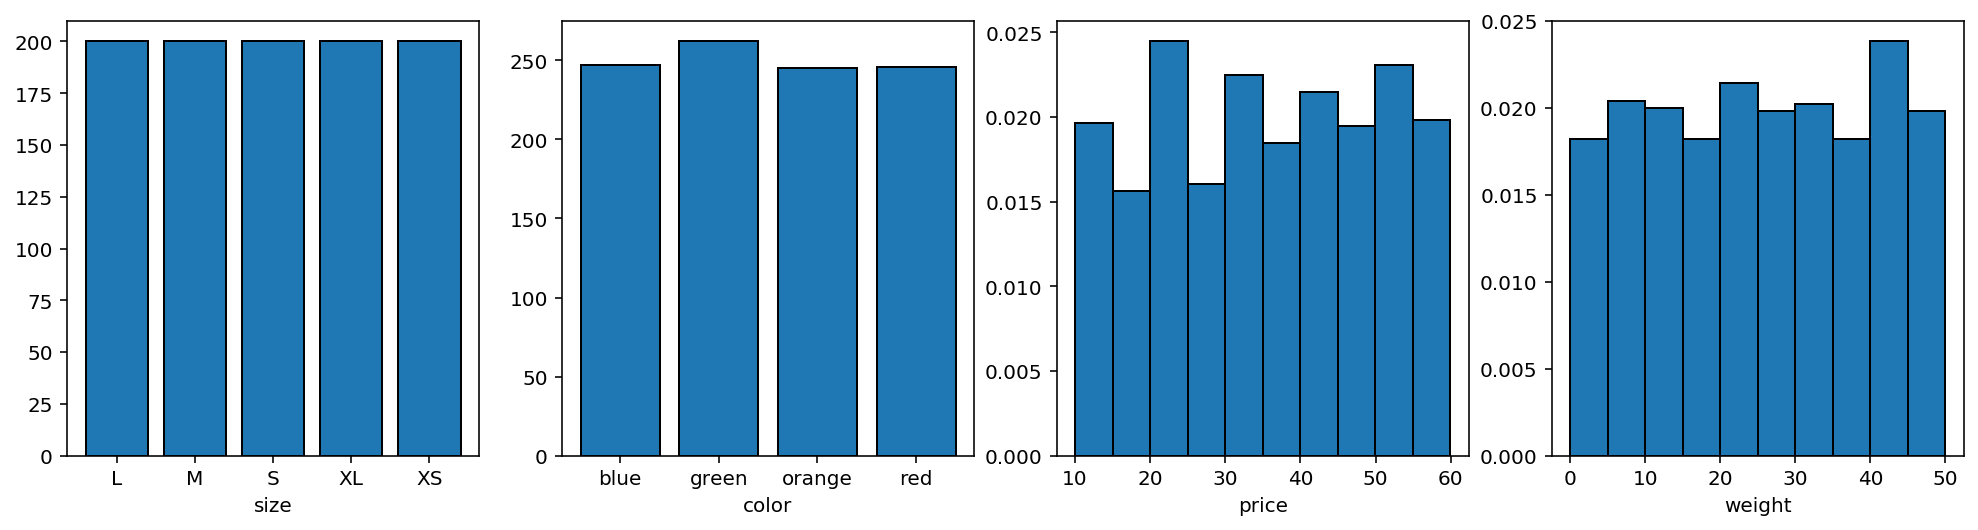

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(17,4))

size_idx, size_count = np.unique(size, return_counts=True)
ax[0].bar(size_idx, height=size_count, edgecolor='black')
ax[0].set_xlabel('size')

color_idx, color_count = np.unique(color, return_counts=True)
ax[1].bar(color_idx, height=color_count, edgecolor='black')
ax[1].set_xlabel('color')

ax[2].hist(price, edgecolor='black',  density=True)
ax[2].set_xlabel('price')

ax[3].hist(weight, edgecolor='black', density=True)
ax[3].set_xlabel('weight')


## 2. KS Test Functionality

In [72]:
# Categorical vs. continuous KS functionality
def create_categorical_masks(X):
    masks = {}
    for x in np.unique(X):
        masks[x] = X == x
    return masks


def cat_cont_ks(X1, X2):
    """X1 -> categorical, X2 -> continuous"""
    
    cat_masks = create_categorical_masks(X1)
    
    X2_subsets = {x2: X2[mask] for x2, mask in cat_masks.items()}
    
    ks_results = {}
    for x1_i, x2_i in X2_subsets.items():
        for x1_j, x2_j in X2_subsets.items():
            if x1_i != x1_j:
                ks_results[(x1_i, x1_j)] = ks_2samp(x2_i, x2_j).statistic

    return ks_results


# Continuous KS functionality
def bin_even_width(X, num_bins=10):
    X_hist = np.histogram(X, bins=num_bins)
    bins = set()
    for idx in range(len(X_hist[1]) - 1):
        bins.add((X_hist[1][idx], X_hist[1][idx + 1]))
    return bins
    
def bin_even_count(X, num_bins=10):
    X_sorted = np.sort(X)
    X_len = len(X_sorted)
    bin_size = int(X_len / num_bins)
    bins = set()
    for i in range(num_bins):
        bin_lower = X_sorted[i * bin_size] 
        bin_upper = X_sorted[(i + 1) * bin_size - 1] 
        bins.add((bin_lower, bin_upper))
    return bins


def create_continuous_masks(X, bins):
    masks = {}
    for bin_x in bins:
        masks[bin_x] = (X >= bin_x[0]) & (X <= bin_x[1]) 
    return masks


def cont_cont_ks(X1, X2, bin_func=bin_even_width, **kwargs):
    """X1 -> continuous, X2 -> continuous"""
    
    bins = bin_func(X1, **kwargs)

    cont_masks = create_continuous_masks(X1, bins)
    
    X2_subsets = {x2: X2[mask] for x2, mask in cont_masks.items()}
    
    ks_results = {}
    for x1_i, x2_i in X2_subsets.items():
        for x1_j, x2_j in X2_subsets.items():
            if x1_i != x1_j:
                ks_results[(x1_i, x1_j)] = ks_2samp(x2_i, x2_j).statistic

    return ks_results


# Categorical vs categorical ks functionality
def cat_cat_ks(X1, X2):
    """X1 -> categorical, X2 -> categorical"""
    
    cat_masks = create_categorical_masks(X1)
    
    X2_subsets = {x2: X2[mask] for x2, mask in cat_masks.items()}
    
    ks_results = {}
    for x1_i, x2_i in X2_subsets.items():
        for x1_j, x2_j in X2_subsets.items():
            if x1_i != x1_j:
                ks_results[(x1_i, x1_j)] = ks_2samp(x2_i, x2_j).statistic

    return ks_results

## 3. MI functionality

In [26]:
import mutual_information_estimators

def normalize_kl(kl_div_val):
    return 1 - np.exp(-kl_div_val)

# 4. Run Experiment

In [62]:
experiment_log_dict = {'X': [], 'Y': [], 'ks_statistic': [], 'MI': [], 'MI_normed': []}

In [63]:
def update_experiment_log(experiment_log_dict, x, y, ks, mi, mi_normed):
    experiment_log_dict['X'].append(x)
    experiment_log_dict['Y'].append(y)
    experiment_log_dict['ks_statistic'].append(ks)
    experiment_log_dict['MI'].append(mi)
    experiment_log_dict['MI_normed'].append(mi_normed)
    return experiment_log_dict
    
    
# def run_trial(X, Y, x_name, y_name, experiment_log_dict):
#     ks_output = np.array(list(cat_cont_ks(X, Y).values())).mean()
#     mi_output = micd(np.asmatrix(X).T, np.asmatrix(Y).T)
#     mi_output_normed = normalize_kl(mi_output)

#     experiment_log_dict = update_experiment_log(
#         experiment_log_dict, 'x_name', 'y_name', ks_output, mi_output, mi_output_normed
#     )

#     print(f'KS approach: {ks_output}')
#     print(f'MI approach: {mi_output}')
#     print(f'MI approach normed: {normalize_kl(mi_output)}')
    
#     return experiment_log_dict

# experiment_log_dict = run_trial(price, size, 'price', 'size', experiment_log_dict)

#### Categorical vs. Continous
Compare size and price (should be high mutual information).

#### 2.1 `Size` vs. `Price`

In [64]:
ks_output = np.array(list(cat_cont_ks(size, price).values())).mean()
mi_output = micd(np.asmatrix(price).T, np.asmatrix(size).T)
mi_output_normed = normalize_kl(mi_output)

experiment_log_dict = update_experiment_log(
    experiment_log_dict, 'price', 'size', ks_output, mi_output, mi_output_normed
)

print(f'KS approach: {ks_output}')
print(f'MI approach: {mi_output}')
print(f'MI approach normed: {normalize_kl(mi_output)}')

KS approach: 0.97
MI approach: 2.1483618745531223
MI approach normed: 0.8833248701881237


In [65]:
experiment_log_dict

{'X': ['price'],
 'Y': ['size'],
 'ks_statistic': [0.97],
 'MI': [2.1483618745531223],
 'MI_normed': [0.8833248701881237]}

#### 2.2 `Color` vs. `Price`

In [66]:
ks_output = np.array(list(cat_cont_ks(color, price).values())).mean()
mi_output = micd(np.asmatrix(price).T, np.asmatrix(color).T)
mi_output_normed = normalize_kl(mi_output)

experiment_log_dict = update_experiment_log(
    experiment_log_dict, 'price', 'color', ks_output, mi_output, mi_output_normed
)

print(f'KS approach: {ks_output}')
print(f'MI approach: {mi_output}')
print(f'MI approach normed: {normalize_kl(mi_output)}')

KS approach: 0.046599408881253884
MI approach: 0.03590827085760484
MI approach normed: 0.03527121683155654


## 3. Continuous vs. Continuous

#### 3.1 `weight` vs `price`

In [67]:
ks_output = np.array(list(cont_cont_ks(weight, price).values())).mean()
mi_output = mi(np.asmatrix(price).T, np.asmatrix(weight).T)
mi_output_normed = normalize_kl(mi_output)

experiment_log_dict = update_experiment_log(
    experiment_log_dict, 'weight', 'price', ks_output, mi_output, mi_output_normed
)

print(f'KS approach: {ks_output}')
print(f'MI approach: {mi_output}')
print(f'MI approach normed: {normalize_kl(mi_output)}')

KS approach: 0.11715132621668146
MI approach: 0.015127948322456014
MI approach normed: 0.0150140957538627


#### 3.2 `price` vs. `tax`

In [68]:
ks_output = np.array(list(cont_cont_ks(tax, price).values())).mean()
mi_output = mi(np.asmatrix(price).T, np.asmatrix(tax).T)
mi_output_normed = normalize_kl(mi_output)

experiment_log_dict = update_experiment_log(
    experiment_log_dict, 'tax', 'price', ks_output, mi_output, mi_output_normed
)

print(f'KS approach: {ks_output}')
print(f'MI approach: {mi_output}')
print(f'MI approach normed: {normalize_kl(mi_output)}')

KS approach: 0.948340156164057
MI approach: 2.840376662038356
MI approach normed: 0.941596336621904


## 4. Categorical vs. Categorical

#### 4.1 Color vs size

In [73]:
ks_output = np.array(list(cat_cat_ks(color, size).values())).mean()
mi_output = midd(np.asmatrix(color).T, np.asmatrix(size).T)
mi_output_normed = normalize_kl(mi_output)

experiment_log_dict = update_experiment_log(
    experiment_log_dict, 'color', 'size', ks_output, mi_output, mi_output_normed
)

print(f'KS approach: {ks_output}')
print(f'MI approach: {mi_output}')
print(f'MI approach normed: {normalize_kl(mi_output)}')

KS approach: 0.03727691338299967
MI approach: 0.004490046433180073
MI approach normed: 0.004479981244716824


In [263]:
size_v_color = cat_cat_mut_inf(size, color)
np.array(list(size_v_color.values())).mean()

0.03500000000000001

#### 4.2 Size vs container

In [74]:
ks_output = np.array(list(cat_cat_ks(container, size).values())).mean()
mi_output = midd(np.asmatrix(container).T, np.asmatrix(size).T)
mi_output_normed = normalize_kl(mi_output)

experiment_log_dict = update_experiment_log(
    experiment_log_dict, 'container', 'size', ks_output, mi_output, mi_output_normed
)

print(f'KS approach: {ks_output}')
print(f'MI approach: {mi_output}')
print(f'MI approach normed: {normalize_kl(mi_output)}')

KS approach: 0.2993406031380715
MI approach: 0.31789871624329913
MI approach normed: 0.27232351350946193
